In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple
from math import sqrt
import pickle
%matplotlib inline

In [2]:
det_params_names = ['block_scale', 'sub_threshold', 'retr_type', 'retr_approx', 'min_poly']
DetectorParams = namedtuple('DetectorParams', det_params_names)

class ContoursDetector:
    def __init__(self, det_params):
        self.det_params = det_params        
        
    def create_threshold_image(self, image, reverse_color=False):   
        if reverse_color:
            image = cv2.bitwise_not(image)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        block_size = int(max(image.shape[0], image.shape[1]) / self.det_params.block_scale)
        if block_size % 2 == 0:
            block_size += 1
        thresh_type = cv2.ADAPTIVE_THRESH_MEAN_C
        sub_thres = self.det_params.sub_threshold
        return cv2.adaptiveThreshold(gray_image, 255, thresh_type, cv2.THRESH_BINARY, block_size, sub_thres)       
        
    def is_contour_valid(self, contour):
        poly_tolerance = 0.01 * cv2.arcLength(contour, True)
        poly_approx = cv2.approxPolyDP(contour, poly_tolerance, True)
        return (len(poly_approx) > self.det_params.min_poly)
        
    def get_white_contours(self, image, reverse_color=False):
        threshold = self.create_threshold_image(image, reverse_color)
        retr_type, retr_approx = self.det_params.retr_type, self.det_params.retr_approx        
        contours, _ = cv2.findContours(threshold, retr_type, retr_approx)
        return filter(self.is_contour_valid, contours)        
        
    def get_contours(self, image):
        return self.get_white_contours(image, False) + self.get_white_contours(image, True)
    
    def create_contours_image(self, image, reverse_color=False):
        contours_list = self.get_white_contours(image, reverse_color)
        contours_image = image.copy()        
        for cnt in contours_list:
            contour_color = np.random.randint(255, size=3)
            cv2.drawContours(contours_image, [cnt], 0, contour_color, -1)   
        return contours_image
    
    def plot_internal_image(self, image, cmap=None):
        plt.figure(figsize=(14, 9))        
        plt.imshow(image, cmap=cmap)
        plt.show()        
    
    def plot_contours_images(self, image):
        self.plot_internal_image(image)
        self.plot_internal_image(self.create_threshold_image(image, False), 'gray')
        self.plot_internal_image(self.create_contours_image(image, False))        
        self.plot_internal_image(self.create_threshold_image(image, True), 'gray')
        self.plot_internal_image(self.create_contours_image(image, True))
        

In [3]:
class ImageFragmentExtractor:
    def __init__(self, image, fragment_scale):
        self.image = image
        self.fragment_scale = fragment_scale
        
    def get_scaled_size(self, start_point, end_point):
        center_point = (start_point + end_point) / 2.0
        start_scaled = center_point - self.fragment_scale * (center_point - start_point)
        end_scaled = center_point + self.fragment_scale * (end_point - center_point)
        return int(start_scaled), int(end_scaled)
    
    def extract_image_fragment(self, contour):
        start_x, start_y, width, height = cv2.boundingRect(contour)
        width, height = max(width, height), max(width, height)
        start_x, end_x = self.get_scaled_size(start_x, start_x + width)
        start_y, end_y = self.get_scaled_size(start_y, start_y + height)
        return ((start_x, start_y), self.image[start_y:end_y, start_x:end_x, :])

In [4]:
class ImagePointFilter:
    def __init__(self, filter_radius):
        self.filter_radius = filter_radius
        self.occupied_point_list = []
        
    def get_point_distance_square(self, point1, point2):
        px, py = point1[0] - point2[0], point1[1] - point2[1]
        return (px ** 2 + py ** 2)
        
    def validate_point(self, point):
        for occupied_point in self.occupied_point_list:
            dist = self.get_point_distance_square(point, occupied_point)
            if dist <= self.filter_radius ** 2:
                return False
        self.occupied_point_list.append(point)
        return True
        
    def filter_points(self, point_list):
        return filter(self.validate_point, point_list)

In [5]:
class ImageFragmentFilter:
    def __init__(self, min_edge_size, max_edge_size, filter_radius=0):
        self.min_edge_size = min_edge_size
        self.max_edge_size = max_edge_size
        self.filter_radius = filter_radius
        self.image_point_filter = ImagePointFilter(filter_radius)
        
    def filter_fragments(self, fragment_list):
        edge_size_func = (lambda x: min(x[1].shape[0], x[1].shape[1]))
        fragment_list = filter(lambda x: edge_size_func(x) > self.min_edge_size, fragment_list)
        fragment_list = filter(lambda x: edge_size_func(x) < self.max_edge_size, fragment_list)
        if self.filter_radius == 0:
            return fragment_list
        point_list = map(lambda x: x[0], fragment_list)
        point_set = set(self.image_point_filter.filter_points(point_list))
        filtered_fragment_list = []
        for point, image in fragment_list:  
            if point in point_set:
                point_set.remove(point)
                filtered_fragment_list.append((point, image))
        return filtered_fragment_list

In [6]:
def plot_fragments(fragment_list, plot_size=(16, 16), one_dim_subplot_count=8):
    plot_counter = 0
    subplot_count = one_dim_subplot_count ** 2
    for fragment in fragment_list:
        if plot_counter % subplot_count == 0:
            plt.figure(figsize=plot_size)
        plot_counter += 1
        plot_num = plot_counter % subplot_count
        if plot_num == 0:
            plot_num = subplot_count
        plt.subplot(one_dim_subplot_count, one_dim_subplot_count, plot_num) 
        plt.imshow(fragment[1], cmap='gray', vmin=0, vmax=255)
        if plot_counter % subplot_count == 0:
            plt.show()

def get_min_fragment_size(image):
    return int(max(image.shape[0], image.shape[1]) / 100)

def get_max_fragment_size(image):
    return int(max(image.shape[0], image.shape[1]) / 10)
            
def resize_fragment(fragment):
    return (fragment[0], cv2.resize(fragment[1], (32, 32))) 

def gray_fragment(fragment):
    return (fragment[0], cv2.cvtColor(fragment[1], cv2.COLOR_RGB2GRAY))

def test_image(image, im_id):
    det_params = DetectorParams(30, -30, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE, 3)
    contours_detector = ContoursDetector(det_params)
    contours_detector.plot_contours_images(image)
    contour_list = contours_detector.get_contours(image)
    fragment_extractor = ImageFragmentExtractor(image, 1.1)  
    min_fragment_size = get_min_fragment_size(image)
    max_fragment_size = get_max_fragment_size(image)    
    image_fragment_filter = ImageFragmentFilter(min_fragment_size, max_fragment_size)    
    fragment_list = map(fragment_extractor.extract_image_fragment, contour_list)
    fragment_list = image_fragment_filter.filter_fragments(fragment_list)
    fragment_list = map(lambda x: resize_fragment(x), fragment_list)
    fragment_list = map(lambda x: gray_fragment(x), fragment_list)    
    print("Fragments count: %d" % (len(fragment_list)))
    print(fragment_list[0][1])
    pickle.dump(fragment_list, open("{0}.p".format(im_id), "wb"))    
    plot_fragments(fragment_list)
    
def test_params(filepath_list):
    for filepath in filepath_list:
        image = cv2.imread(filepath, 1)
        print(image)
        test_image(image, filepath)

[[[131 156 182]
  [124 149 175]
  [114 139 165]
  ..., 
  [120 184 195]
  [121 184 192]
  [113 175 183]]

 [[121 146 172]
  [118 143 169]
  [107 132 158]
  ..., 
  [119 181 192]
  [123 185 193]
  [123 182 191]]

 [[103 128 154]
  [112 137 163]
  [114 137 163]
  ..., 
  [118 176 188]
  [122 178 189]
  [129 184 193]]

 ..., 
 [[121 128 145]
  [128 135 152]
  [137 144 161]
  ..., 
  [103 169 247]
  [110 177 252]
  [115 180 255]]

 [[131 138 153]
  [130 137 152]
  [127 134 149]
  ..., 
  [105 169 247]
  [113 178 253]
  [114 179 254]]

 [[143 151 164]
  [140 148 161]
  [127 135 148]
  ..., 
  [105 169 247]
  [112 177 252]
  [112 177 252]]]


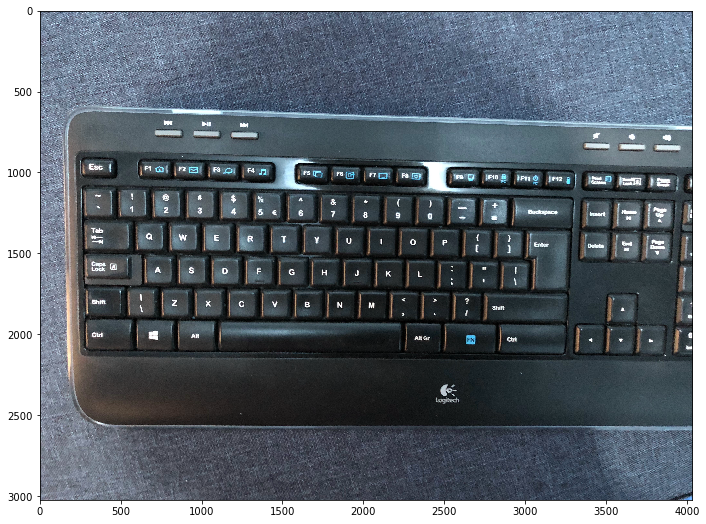

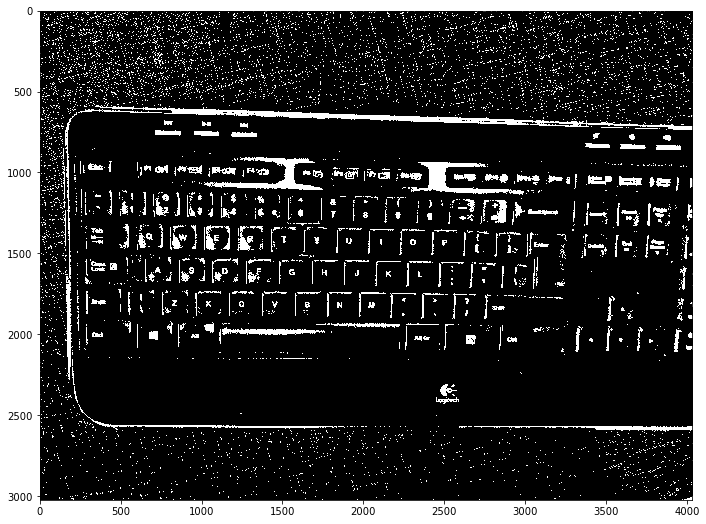

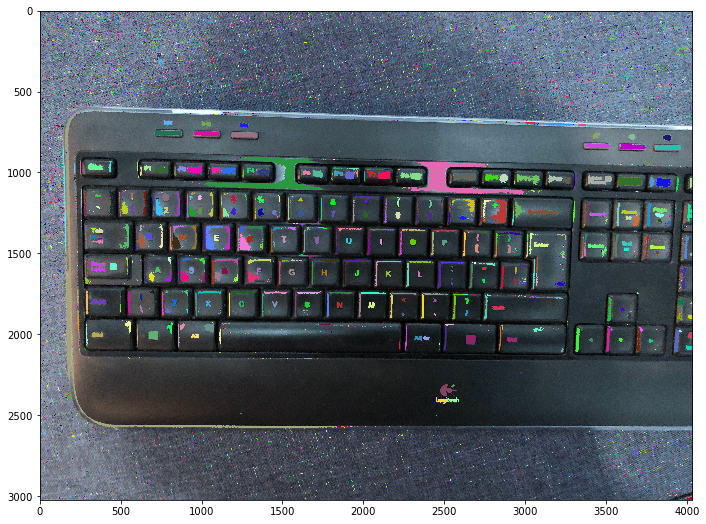

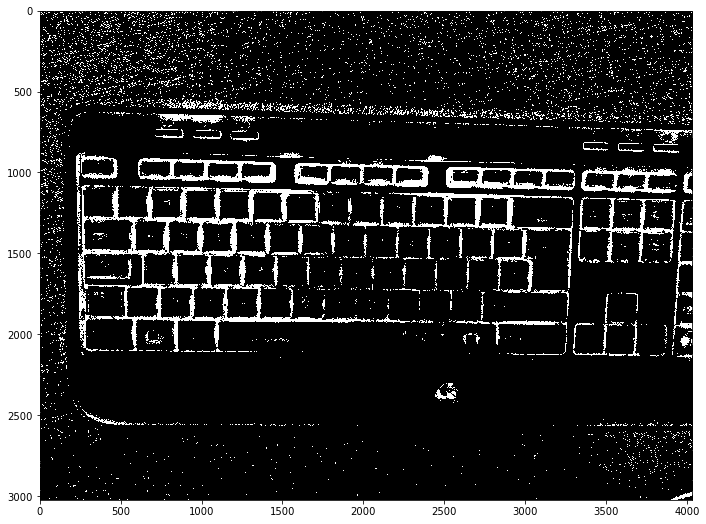

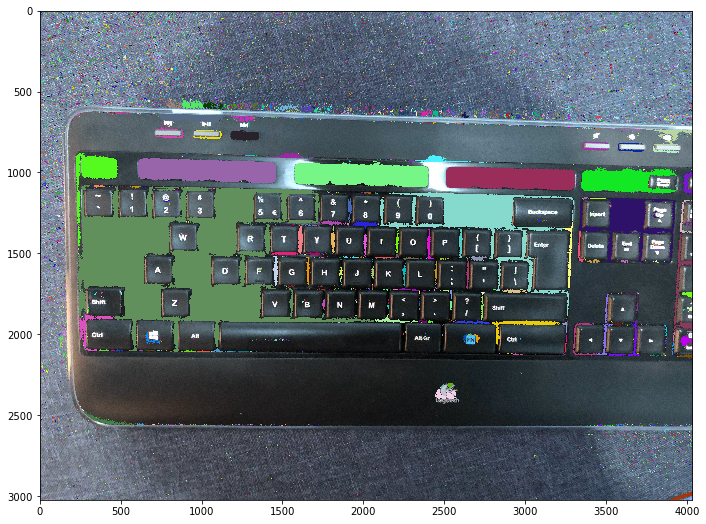

Fragments count: 515
[[ 14  25  17 ...,  25  30  24]
 [ 28  36  61 ...,  29  25  27]
 [ 20  62 130 ...,  26  27  19]
 ..., 
 [ 22  23  22 ...,  24  24  28]
 [ 23  25  27 ...,  30  31  25]
 [ 24  25  20 ...,  16  24  23]]


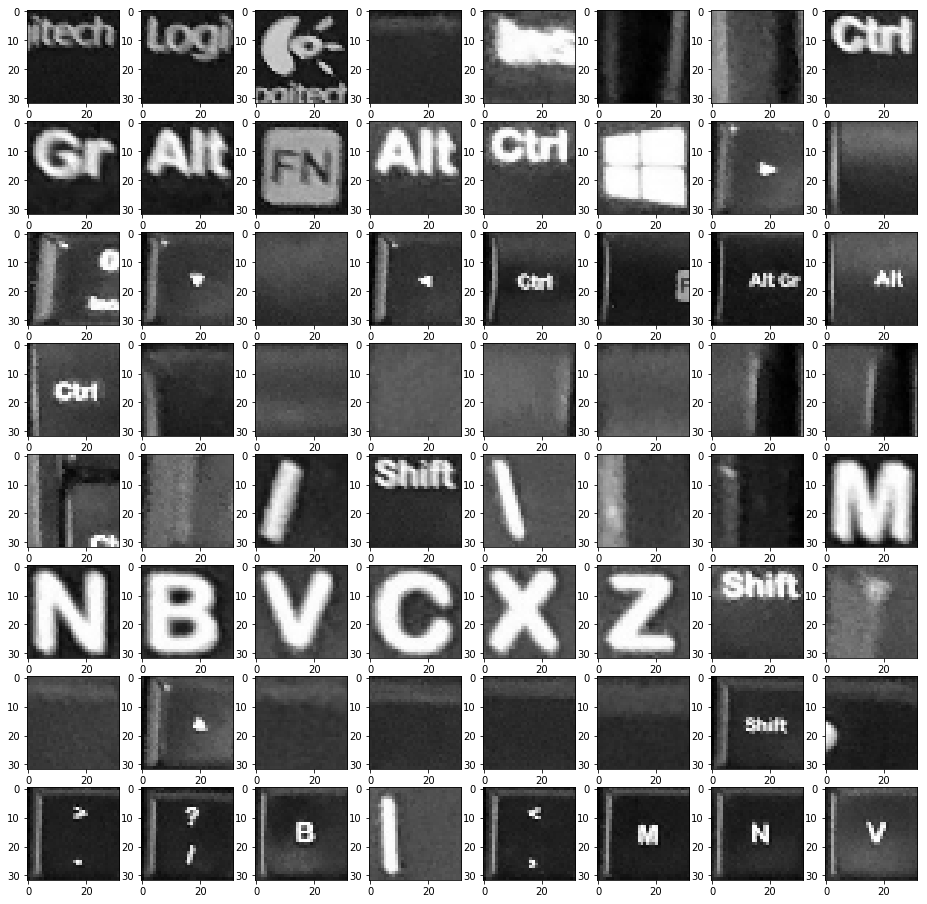

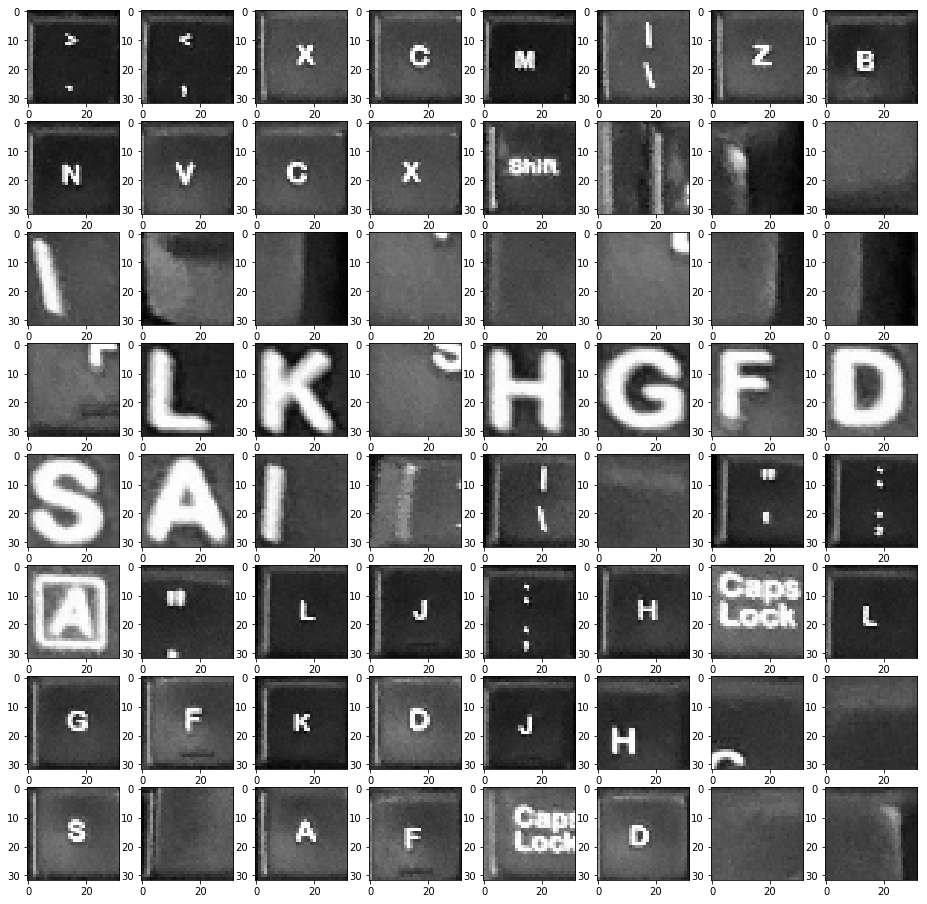

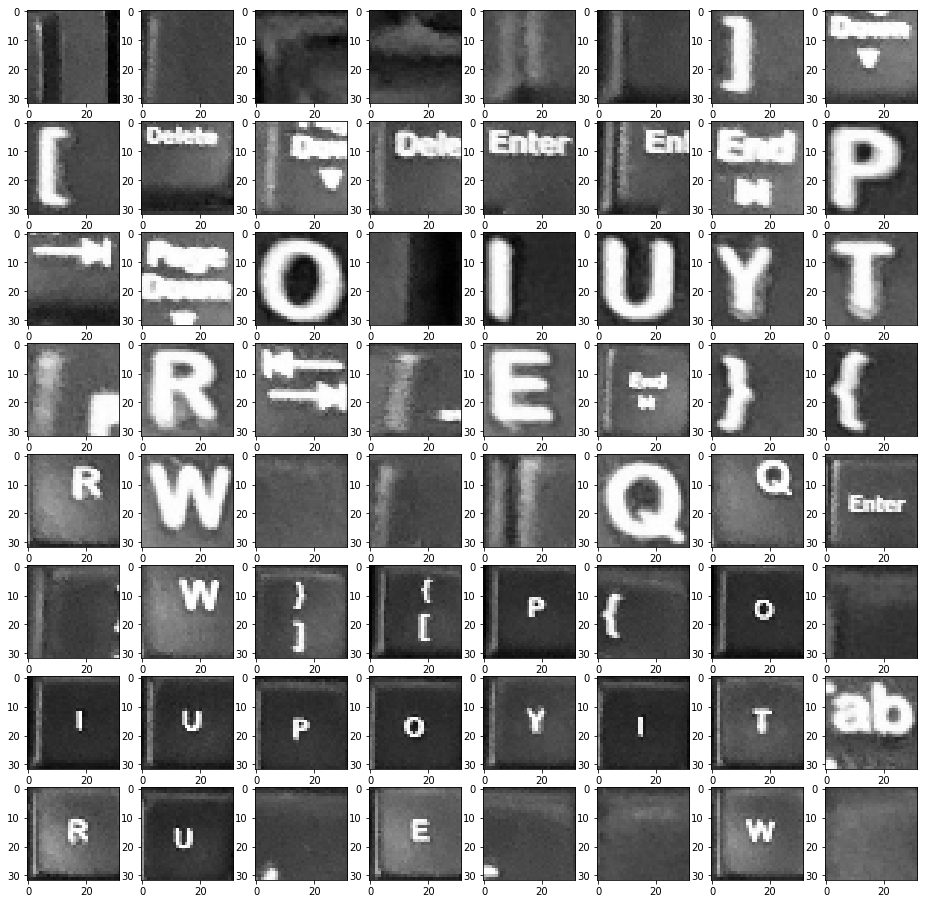

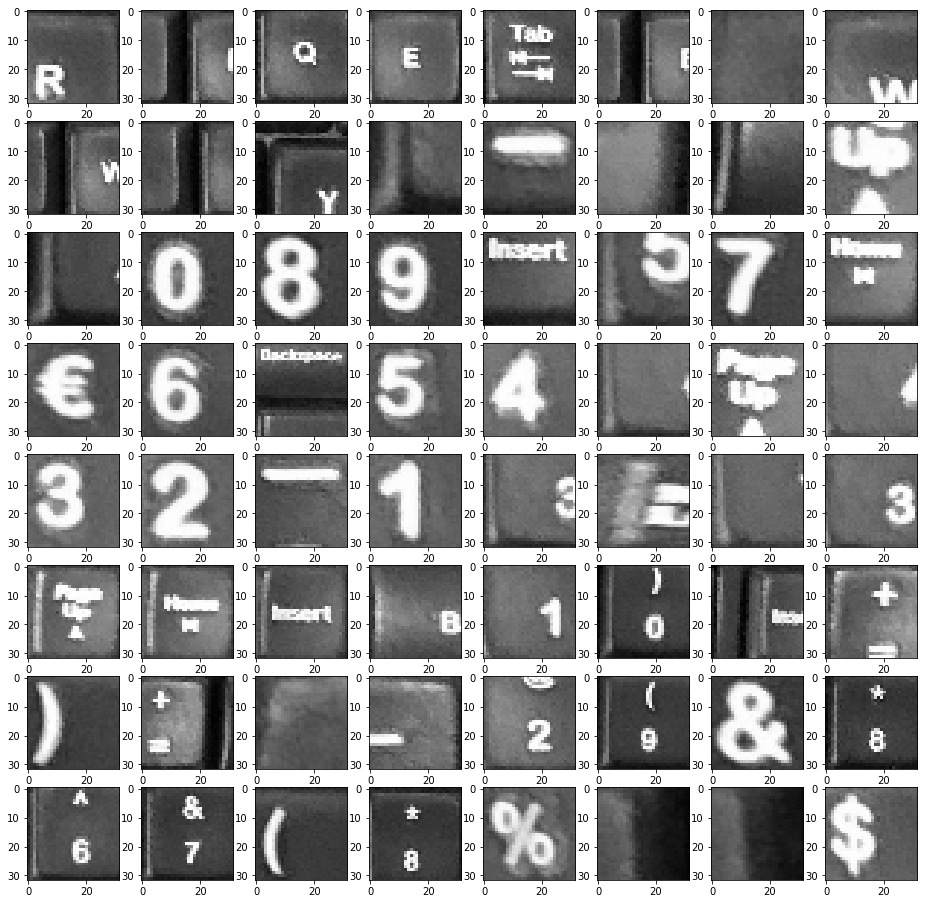

KeyboardInterrupt: 

In [7]:
filepath_list = map(lambda x: "../keyboards/images/keyboard{0}.jpg".format(x), [1])
test_params(filepath_list)